# Load E. coli promoter, iModulon, and TPM data in XY dfs

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import random
random.seed(7) #10



import utils as u
import torch_utils as tu

In [2]:
upstream_region_file = 'ec_iMod_out/loci_in_top_100perc_NO_OP_upstream_regions_w300_min20.fa'
op_file = 'ec_iMod_out/loci_in_top_100perc_op83.txt'
data_mat_file = 'ec_iMod_out/iMod_download/log_tpm.tsv'
sample2cond_file = 'ec_iMod_out/ecoli_sample2condition.txt'
sample_file = None
condition_file = None

loc2seq, op_leads, tpm_df, sample2condition, samples, conditions, meta_df = u.load_data(
    upstream_region_file,
    op_file,
    data_mat_file, 
    sample2cond_file, 
    sample_file, 
    condition_file,
)

In [3]:
print("number of genes with seqs:",len(loc2seq))
print("number of operon leading genes:", len(op_leads))
print("number of samples:", len(samples))
print("number of conditions:", len(conditions))
print("TPM df:",tpm_df.shape)
print("meta df:",meta_df.shape if meta_df else None)

number of genes with seqs: 3832
number of operon leading genes: 2220
number of samples: 278
number of conditions: 154
TPM df: (3923, 279)
meta df: None


In [4]:
tpm_df.head()

,locus_tag,control__wt_glc__1,control__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
0,b0002,11.006653,11.130196,11.704951,11.888217,11.064810,10.779071,9.976401,10.291135,11.229767,...,10.271327,10.276565,11.148538,11.170578,11.676604,11.726097,11.881529,11.923237,11.496410,11.552762
1,b0003,10.415654,10.523138,11.423835,11.803781,10.776984,10.597810,9.596833,10.191503,10.897938,...,10.160291,10.116861,10.314322,10.392251,10.916426,10.909277,11.023924,11.038426,10.624301,10.764195
2,b0004,10.594871,10.725062,10.457270,10.779162,10.394971,10.113950,8.741617,9.082231,10.185151,...,10.475069,10.434352,10.679541,10.723953,11.143310,11.112721,11.184795,11.241845,10.953206,11.001006
3,b0005,6.316102,6.258499,5.422129,5.336121,6.716069,6.410864,4.626949,4.756153,6.527653,...,5.979079,5.705586,6.306120,6.291340,5.058537,4.835550,5.448097,5.757951,5.873964,5.808618
4,b0006,6.915771,6.897597,6.775645,6.782605,6.761813,6.816532,6.686767,6.860036,6.862147,...,8.371287,8.322390,8.137515,8.071837,7.354131,7.365536,7.328101,7.314761,8.057750,8.105213


In [5]:
loci_with_exp_data = set(tpm_df['locus_tag'].values)
print(len(loci_with_exp_data))

3923


In [6]:
from Bio import SeqIO

# def get_feature_tuples_from_genbank(gb_file):
#     '''
#     Given a genbank file, parse out all of it's features into a 5-tuple 
#     of (start_coord, end_coord,locus_tag,gene_symbol,type).
#     '''
#     # Use BioPython genbank parser
#     seq_record = SeqIO.parse(gb_file, "genbank").__next__()
    
#     feat_list = []
#     # Loop over the genome file, get the CDS features on each of the strands
#     for feature in seq_record.features:
#         if 'locus_tag' in feature.qualifiers:
#             # get  locus tag 
#             lt = feature.qualifiers['locus_tag'][0]
#             # get the gene symbol if available, otherwise leave blank
#             g = "" if 'gene' not in feature.qualifiers else feature.qualifiers['gene'][0]
            
#             feat_list.append((feature.location.start.position,
#                              feature.location.end.position,
#                              feature.strand,
#                              lt,
#                              g,
#                              feature.type))
            
#     return feat_list

def get_loc_info_from_gb(genbank_path,feat_exclude=['gene','misc_feature']):
    '''
    Given a genbank file, parse it and return a dictionary of locus and the 
    gene, product and type fields
    '''
    seq_record = SeqIO.parse(genbank_path, "genbank").__next__()
    data = []
    # Loop over the genome file, get the features on each of the strands
    for feature in seq_record.features:
        if feature.type not in feat_exclude:
            if 'locus_tag' in feature.qualifiers: # exclude features without a locus tag
                # get  locus tag, feature name and product
                lt = feature.qualifiers['locus_tag'][0]
                start = feature.location.start.position
                g = "" if 'gene' not in feature.qualifiers else feature.qualifiers['gene'][0]
                prod = "" if 'product' not in feature.qualifiers else feature.qualifiers['product'][0]
                t = feature.type
                strand = feature.strand

                data.append((lt,g,prod,t,strand,start))

    return pd.DataFrame(data,columns=['locus_tag','gene','product','type','strand','start'])

In [7]:
#gb_feats = get_feature_tuples_from_genbank('ec_iMod_out/ecoli_NC_000913.3.gb')

In [8]:
locus_info_df = get_loc_info_from_gb('ec_iMod_out/ecoli_NC_000913.3.gb')
print(locus_info_df.shape)
locus_info_df.head()

(4522, 6)


,locus_tag,gene,product,type,strand,start
0,b0001,thrL,thr operon leader peptide,CDS,1,189
1,b0002,thrA,fused aspartate kinase/homoserine dehydrogenase 1,CDS,1,336
2,b0003,thrB,homoserine kinase,CDS,1,2800
3,b0004,thrC,threonine synthase,CDS,1,3733
4,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233


In [9]:
# filter locus_info to only the loci represented in the Palsson TPM data
locus_info_df = locus_info_df[locus_info_df['locus_tag'].isin(loci_with_exp_data)]
print(locus_info_df.shape)
locus_info_df.head()

(3841, 6)


,locus_tag,gene,product,type,strand,start
1,b0002,thrA,fused aspartate kinase/homoserine dehydrogenase 1,CDS,1,336
2,b0003,thrB,homoserine kinase,CDS,1,2800
3,b0004,thrC,threonine synthase,CDS,1,3733
4,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233
5,b0006,yaaA,DNA binding and peroxide stress response prote...,CDS,-1,5682


In [13]:
# make the df into a dict - some minor ways to de-duplicate some loci and use the entry with more info
def make_loc2info_dict(df):
    d = {}
    for i, row in df.iterrows():
        lt,g,p,t,s,st = row.values
        if lt in d:
            if p == "":
                # if product is empty and lt is in dict, just skip
                continue
        else:
            d[lt] = {'gene':g,
                     'product':p,
                     'type':t,
                     'strand':s,
                     'start':st}
    return d

In [14]:
locus2info = make_loc2info_dict(locus_info_df)

In [15]:
len(locus2info)

3832

## add upstream region to gene info

In [16]:
locus_info_df['upstream_region'] = locus_info_df['locus_tag'].apply(lambda x: loc2seq[x])
locus_info_df.head()

,locus_tag,gene,product,type,strand,start,upstream_region
1,b0002,thrA,fused aspartate kinase/homoserine dehydrogenase 1,CDS,1,336,CTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGG...
2,b0003,thrB,homoserine kinase,CDS,1,2800,CTGTCACAACTCGACGATCTCTTTGCCGCGCGCGTGGCGAAGGCCC...
3,b0004,thrC,threonine synthase,CDS,1,3733,TCACGCCTGCTATTCCCGTCAGCCTGAGCTTGCCGCGAAGCTGATG...
4,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...
5,b0006,yaaA,DNA binding and peroxide stress response prote...,CDS,-1,5682,CACCTTGCTAAGCCTTCCGCTGATGTGGCAACTGGCAGATATCATA...


# load in the iMod A matrix

In [18]:
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = M.columns
M.index.name="locus_tag"
M = M.reset_index()
M.head()

,locus_tag,0,1,2,3,4,5,6,7,8,...,82,83,84,85,86,87,88,89,90,91
0,b0002,0.072693,-0.006320,-0.038374,-0.010045,-0.004345,-0.005599,0.009043,-0.005072,-0.012186,...,-0.010152,-0.012124,-0.012027,-0.002123,-0.000036,-0.013667,-0.018883,0.004408,-0.006315,-0.001780
1,b0003,0.015975,-0.009969,-0.024571,-0.006775,-0.003583,0.006680,-0.010841,-0.012620,-0.003685,...,0.004702,0.004402,0.001182,-0.004415,-0.001514,-0.005052,0.015502,0.000860,-0.022438,-0.020087
2,b0004,0.015319,-0.003808,-0.027018,-0.004455,-0.008418,0.003245,-0.016494,-0.013818,-0.008104,...,0.003507,0.005342,0.003759,0.000700,0.001859,-0.002344,0.016263,0.002486,-0.016565,-0.014142
3,b0005,0.008229,-0.000685,-0.005215,-0.002029,-0.028069,0.014748,-0.019240,-0.002403,-0.008507,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
4,b0006,-0.004941,-0.001849,-0.002326,0.006075,0.001607,0.009678,0.001661,0.003754,-0.000152,...,-0.014761,0.005071,0.001496,-0.002506,-0.002819,0.005800,0.003975,-0.010976,-0.008756,0.006169


In [19]:
imods

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72',
       '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84',
       '85', '86', '87', '88', '89', '90', '91'],
      dtype='object')

In [20]:
XY_df = locus_info_df.merge(M, on='locus_tag')
XY_df

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0002,thrA,fused aspartate kinase/homoserine dehydrogenase 1,CDS,1,336,CTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGG...,0.072693,-0.006320,-0.038374,...,-0.010152,-0.012124,-0.012027,-0.002123,-0.000036,-0.013667,-0.018883,0.004408,-0.006315,-0.001780
1,b0003,thrB,homoserine kinase,CDS,1,2800,CTGTCACAACTCGACGATCTCTTTGCCGCGCGCGTGGCGAAGGCCC...,0.015975,-0.009969,-0.024571,...,0.004702,0.004402,0.001182,-0.004415,-0.001514,-0.005052,0.015502,0.000860,-0.022438,-0.020087
2,b0004,thrC,threonine synthase,CDS,1,3733,TCACGCCTGCTATTCCCGTCAGCCTGAGCTTGCCGCGAAGCTGATG...,0.015319,-0.003808,-0.027018,...,0.003507,0.005342,0.003759,0.000700,0.001859,-0.002344,0.016263,0.002486,-0.016565,-0.014142
3,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0.008229,-0.000685,-0.005215,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
4,b0006,yaaA,DNA binding and peroxide stress response prote...,CDS,-1,5682,CACCTTGCTAAGCCTTCCGCTGATGTGGCAACTGGCAGATATCATA...,-0.004941,-0.001849,-0.002326,...,-0.014761,0.005071,0.001496,-0.002506,-0.002819,0.005800,0.003975,-0.010976,-0.008756,0.006169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836,b4398,creB,DNA-binding transcriptional regulator CreB,CDS,1,4636006,CGGTGGTATTAAAGGGGGATTGGGTCTGGCGGAAGATACCTCCGAT...,0.003079,-0.004124,-0.004173,...,-0.006814,0.000416,-0.001673,-0.018267,-0.008594,0.000683,0.017012,0.001466,0.003473,0.009348
3837,b4399,creC,sensory histidine kinase CreC,CDS,1,4636695,CCGTCATCCGTATTGGACATTTTGAATTGAATGAACCCGCGGCGCA...,0.001222,-0.000991,0.001095,...,-0.001377,-0.009610,-0.003364,-0.010663,-0.003429,0.007563,0.005413,-0.012420,-0.002899,0.017861
3838,b4400,creD,putative inner membrane protein CreD,CDS,1,4638177,AGTGGATCAGGAACACGTCACGCTTAAGGTGCTGGATACCGGTAGT...,0.016451,-0.007359,0.007993,...,0.004760,0.002644,0.002752,0.015589,-0.014363,-0.021782,-0.016955,-0.000631,0.005144,-0.005738
3839,b4401,arcA,DNA-binding transcriptional dual regulator ArcA,CDS,-1,4639589,ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...,-0.011745,-0.007186,0.001854,...,-0.004273,-0.012568,0.002642,-0.006067,0.002254,-0.007834,-0.006731,0.009084,-0.001517,0.001496


In [21]:
# pd.merge used inner join
print(locus_info_df.shape)
print(M.shape)
print(XY_df.shape)

(3841, 7)
(3923, 93)
(3841, 99)


In [22]:
XY_df

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0002,thrA,fused aspartate kinase/homoserine dehydrogenase 1,CDS,1,336,CTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGG...,0.072693,-0.006320,-0.038374,...,-0.010152,-0.012124,-0.012027,-0.002123,-0.000036,-0.013667,-0.018883,0.004408,-0.006315,-0.001780
1,b0003,thrB,homoserine kinase,CDS,1,2800,CTGTCACAACTCGACGATCTCTTTGCCGCGCGCGTGGCGAAGGCCC...,0.015975,-0.009969,-0.024571,...,0.004702,0.004402,0.001182,-0.004415,-0.001514,-0.005052,0.015502,0.000860,-0.022438,-0.020087
2,b0004,thrC,threonine synthase,CDS,1,3733,TCACGCCTGCTATTCCCGTCAGCCTGAGCTTGCCGCGAAGCTGATG...,0.015319,-0.003808,-0.027018,...,0.003507,0.005342,0.003759,0.000700,0.001859,-0.002344,0.016263,0.002486,-0.016565,-0.014142
3,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0.008229,-0.000685,-0.005215,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
4,b0006,yaaA,DNA binding and peroxide stress response prote...,CDS,-1,5682,CACCTTGCTAAGCCTTCCGCTGATGTGGCAACTGGCAGATATCATA...,-0.004941,-0.001849,-0.002326,...,-0.014761,0.005071,0.001496,-0.002506,-0.002819,0.005800,0.003975,-0.010976,-0.008756,0.006169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836,b4398,creB,DNA-binding transcriptional regulator CreB,CDS,1,4636006,CGGTGGTATTAAAGGGGGATTGGGTCTGGCGGAAGATACCTCCGAT...,0.003079,-0.004124,-0.004173,...,-0.006814,0.000416,-0.001673,-0.018267,-0.008594,0.000683,0.017012,0.001466,0.003473,0.009348
3837,b4399,creC,sensory histidine kinase CreC,CDS,1,4636695,CCGTCATCCGTATTGGACATTTTGAATTGAATGAACCCGCGGCGCA...,0.001222,-0.000991,0.001095,...,-0.001377,-0.009610,-0.003364,-0.010663,-0.003429,0.007563,0.005413,-0.012420,-0.002899,0.017861
3838,b4400,creD,putative inner membrane protein CreD,CDS,1,4638177,AGTGGATCAGGAACACGTCACGCTTAAGGTGCTGGATACCGGTAGT...,0.016451,-0.007359,0.007993,...,0.004760,0.002644,0.002752,0.015589,-0.014363,-0.021782,-0.016955,-0.000631,0.005144,-0.005738
3839,b4401,arcA,DNA-binding transcriptional dual regulator ArcA,CDS,-1,4639589,ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...,-0.011745,-0.007186,0.001854,...,-0.004273,-0.012568,0.002642,-0.006067,0.002254,-0.007834,-0.006731,0.009084,-0.001517,0.001496


In [23]:
XY_df.to_csv('ec_iMod_out/ecoli_seq_M.tsv',sep='\t',index=False)

# filter out genes inside operons

In [24]:
XY_df_op_leads = XY_df[XY_df['locus_tag'].isin(op_leads)]
XY_df_op_leads

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
3,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0.008229,-0.000685,-0.005215,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
5,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0.008111,-0.003929,0.003207,...,-0.000337,-0.010468,0.016122,0.010361,-0.003899,-0.022839,-0.003665,-0.001823,-0.023604,-0.012765
6,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0.008629,-0.001270,-0.005664,...,0.000394,0.007215,-0.000707,-0.012959,-0.002329,0.006391,-0.003650,-0.008537,0.002898,-0.000891
7,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0.002952,0.002053,-0.002882,...,-0.009291,-0.000226,0.016013,0.002179,0.004891,-0.002365,-0.003490,-0.006066,-0.011982,0.011477
8,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0.006142,0.000884,0.008166,...,-0.009214,-0.010588,0.001363,0.003979,-0.005208,0.003190,-0.015137,-0.005784,-0.001302,0.010800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,b4395,ytjC,putative phosphatase,CDS,1,4633796,TGCTGTCACCATCGATGCCAGCTTCAATCGCCACCCAAAAATCAGC...,-0.001867,-0.004820,0.002848,...,-0.007416,0.004508,0.007530,0.013427,-0.003522,-0.008309,-0.001057,-0.010950,-0.001703,0.003105
3834,b4396,rob,DNA-binding transcriptional dual regulator Rob,CDS,-1,4634440,ATACGGTGTCGACCGAACCAATCTCTTCTGCATGAGCCAATGGCCC...,0.007606,-0.001841,0.006282,...,-0.000006,-0.002393,-0.002863,-0.001425,-0.004117,-0.015182,-0.009433,0.010486,-0.000871,0.001517
3835,b4397,creA,PF05981 family protein CreA,CDS,1,4635520,CTTTCGCCGCTACATTGTCGAGCGACAGGGGCTGATCCAGATGACC...,-0.004296,-0.005215,-0.004435,...,-0.003813,-0.005506,-0.003119,-0.001202,-0.002366,0.012681,0.002699,-0.018788,0.006693,0.008076
3839,b4401,arcA,DNA-binding transcriptional dual regulator ArcA,CDS,-1,4639589,ACAATTGAACTTGATATATGTCAACGAAGCGTAGTTTTATTGGGTG...,-0.011745,-0.007186,0.001854,...,-0.004273,-0.012568,0.002642,-0.006067,0.002254,-0.007834,-0.006731,0.009084,-0.001517,0.001496


In [25]:
XY_df_op_leads.to_csv('ec_iMod_out/ecoli_seq_M_opFilt.tsv',sep='\t',index=False)

<AxesSubplot:xlabel='start', ylabel='26'>

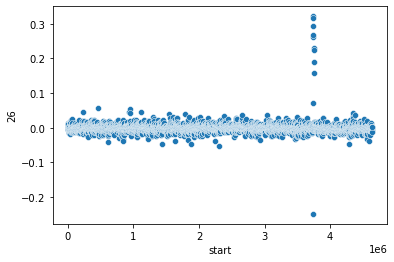

In [32]:
sns.scatterplot(data=XY_df, x='start',y='26')